Plan for Task AB-49
1. Analyze the Schema and Map Data Fields
The provided schema includes the following relevant tables:

wbs.Master_Capability_List: Stores subcategories of capabilities.

references.NAICS_Codes: Contains NAICS codes and their descriptions.

references.Capabilities_Categories: Manages hierarchical categories of capabilities.

wbs.WBS_Task_Map: Maps capabilities to tasks and contractors.

The Excel file contains the following columns:

Classification: Likely corresponds to classification_name in references.Capabilities_Categories.

Category: Maps to category_name in references.Capabilities_Categories.

Service Name: Maps to subcategory_name in wbs.Master_Capability_List.

Description: Maps to subcategory_description in wbs.Master_Capability_List.

NAICS: Links to naics_code in references.NAICS_Codes.

Frameworks: Could be additional metadata (not explicitly mapped in the schema).

PSC: May require a separate mapping or inclusion as metadata.

2. Data Loading Steps
We need to load data into the respective tables while maintaining relationships:

Populate references.NAICS_Codes with unique NAICS codes from the Excel file.

Populate references.Capabilities_Categories with classifications and categories.

Populate wbs.Master_Capability_List with subcategories (service names) and descriptions.

Link subcategories to categories using foreign keys (e.g., parent_category_id).

3. Implementation Steps
Below is a Python script outline using pandas and SQLAlchemy:

Python Script
python
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote
from sqlalchemy.types import String, Integer

# 1. Read Excel File
file_path = "Service Catalog Output_Sprint_3_FINAL_20250225.xlsx"
df = pd.read_excel(file_path)

# 2. Create Database Connection
DB_PASSWORD = "your_password_here"  # Replace with actual password
encoded_password = quote(DB_PASSWORD, safe='')
connection_url = (
    f"postgresql+psycopg2://postgres:{encoded_password}@"
    "advantantus-prod.cmfo86w02i47.us-east-1.rds.amazonaws.com:5432/postgres"
)
engine = create_engine(connection_url)

# 3. Populate NAICS Codes Table
naics_df = df[['NAICS']].drop_duplicates().rename(columns={'NAICS': 'naics_code'})
naics_df['naics_description'] = None  # Placeholder for descriptions if not available
naics_df.to_sql(
    name='NAICS_Codes',
    con=engine,
    schema='references',
    if_exists='append',
    index=False,
    dtype={'naics_code': String(16), 'naics_description': String(255)}
)

# 4. Populate Capabilities Categories Table
categories_df = df[['Classification', 'Category']].drop_duplicates()
categories_df.rename(
    columns={
        'Classification': 'classification_name',
        'Category': 'category_name'
    },
    inplace=True
)
categories_df['category_description'] = None  # Placeholder for descriptions
categories_df.to_sql(
    name='Capabilities_Categories',
    con=engine,
    schema='references',
    if_exists='append',
    index=False,
    dtype={
        'classification_name': String(255),
        'category_name': String(255),
        'category_description': String(255)
    }
)

# 5. Populate Master Capability List Table
capabilities_df = df[['Service Name', 'Description', 'Category']].rename(
    columns={
        'Service Name': 'subcategory_name',
        'Description': 'subcategory_description'
    }
)
capabilities_df['parent_category_id'] = None  # Placeholder for foreign key mapping
capabilities_df.to_sql(
    name='Master_Capability_List',
    con=engine,
    schema='wbs',
    if_exists='append',
    index=False,
    dtype={
        'subcategory_name': String(100),
        'subcategory_description': String(255),
        'parent_category_id': Integer
    }
)

# 6. Map Relationships (Post-Ingestion Updates)
with engine.connect() as conn:
    # Update parent_category_id in Master_Capability_List based on category_name
    conn.execute("""
        UPDATE wbs.Master_Capability_List AS mcl
        SET parent_category_id = cc.category_id
        FROM references.Capabilities_Categories AS cc
        WHERE mcl.parent_category_id IS NULL AND mcl.category_name = cc.category_name;
    """)
Key Considerations
Data Cleaning:

Ensure no duplicate rows are inserted by using .drop_duplicates() on DataFrames.

Handle missing or null values explicitly (e.g., replace empty cells with placeholders).

Foreign Key Relationships:

Establish relationships between subcategories and their parent categories (parent_category_id) after loading data.

Error Handling:

Include try-except blocks for database operations to catch and log errors.

Performance Optimization:

Use batch processing (chunksize) for large datasets to avoid memory issues.

Validation:

Verify data integrity post-ingestion by running SQL queries to check row counts and relationships.

This script aligns with the provided schema and ensures proper loading of the Service Catalog data into the database while maintaining referential integrity.



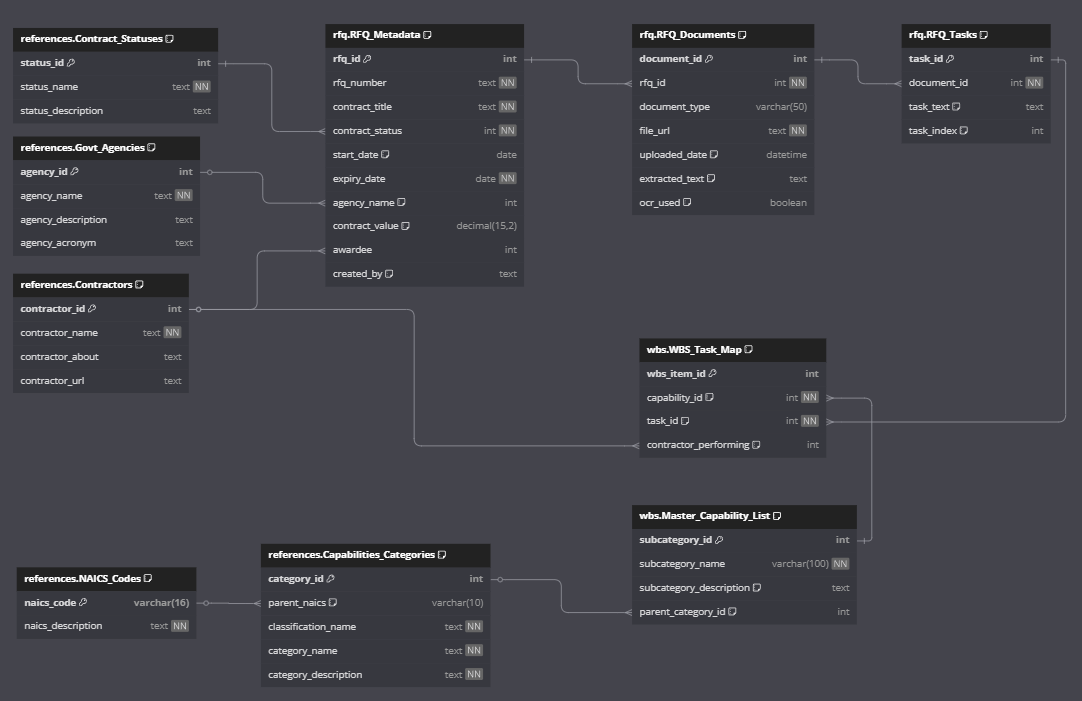

In [6]:
!pip install "psycopg[binary]"  # Installs psycopg3 with binary dependencies
!pip install llama-parse
!pip install nest_asyncio


#LLAMA_CLOUD_API_KEY = "llx-upuZ7s3vg7v4RTuaxFMxDRBzf6XA73Nn2SJxo651qlDtp2pq"  # Get from https://cloud.llamaindex.ai/
DB_PASSWORD = "dG1RWVzD!F4YaneD$$"

**DB** tables build.

EARLY FIX (drop ths later): drop prior tables.

In [13]:
#OPTIONAL Table REbuild- USE WITH CARE AND ONLY IF TRULY NECESSARY
import pandas as pd
from sqlalchemy import create_engine, inspect
from urllib.parse import quote
from sqlalchemy.types import String, Integer
from sqlalchemy import text

# 1. Read Excel File
#file_path = "Service Catalog_916.xlsx"
file_path = "Service Catalog_916_v2.xlsx"

df = pd.read_excel(file_path)

# 2. Create Database Connection
#DB_PASSWORD = "your_password_here"  # Replace with your actual password (defined above in prior mod)
encoded_password = quote(DB_PASSWORD, safe='')
connection_url = (
    f"postgresql+psycopg2://postgres:{encoded_password}@"
    "advantantus-prod.cmfo86w02i47.us-east-1.rds.amazonaws.com:5432/postgres"
)
engine = create_engine(connection_url)

with engine.begin() as conn:
    # This creates a transaction that will be committed at the end of the block
    conn.execute(text('DROP TABLE IF EXISTS "wbs"."Master_Capability_List" CASCADE;'))
    conn.execute(text('DROP TABLE IF EXISTS "references"."Capabilities_Categories" CASCADE;'))
    conn.execute(text('DROP TABLE IF EXISTS "references"."NAICS_Codes" CASCADE;'))

In [14]:
#VERSION 2: FIX Category-level NAIC DUPS by picking the one with the comma,
#           and/or most frequently occuring among sub-categories
import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote
from sqlalchemy.types import String, Integer

# 1. Read Excel File
file_path = "Service Catalog_916_v2.xlsx"
df = pd.read_excel(file_path)

# 2. Create Database Connection
encoded_password = quote(DB_PASSWORD, safe='')
connection_url = (
    f"postgresql+psycopg2://postgres:{encoded_password}@"
    "advantantus-prod.cmfo86w02i47.us-east-1.rds.amazonaws.com:5432/postgres"
)
engine = create_engine(connection_url)

# 3. Create tables in correct order (parent tables first)
with engine.begin() as conn:  # Using begin() to ensure transaction is committed
    # Verify NAICS_Codes doesn't exist before creating
    result = conn.execute(text("""
        SELECT EXISTS (
            SELECT 1 FROM information_schema.tables
            WHERE table_schema = 'references' AND table_name = 'NAICS_Codes'
        );
    """))
    if not result.scalar():
        # Create NAICS_Codes first
        conn.execute(text("""
            CREATE TABLE "references"."NAICS_Codes" (
                naics_code VARCHAR(50) PRIMARY KEY,
                naics_description TEXT
            );
        """))
        print("Created table: references.NAICS_Codes")
    else:
        print("Table references.NAICS_Codes already exists")

    # Verify Capabilities_Categories doesn't exist before creating
    result = conn.execute(text("""
        SELECT EXISTS (
            SELECT 1 FROM information_schema.tables
            WHERE table_schema = 'references' AND table_name = 'Capabilities_Categories'
        );
    """))
    if not result.scalar():
        # Create Capabilities_Categories next
        conn.execute(text("""
            CREATE TABLE "references"."Capabilities_Categories" (
                category_id SERIAL PRIMARY KEY,
                parent_naics VARCHAR(50) REFERENCES "references"."NAICS_Codes"(naics_code),
                classification_name TEXT NOT NULL,
                category_name TEXT NOT NULL,
                category_description TEXT
            );
        """))
        print("Created table: references.Capabilities_Categories")
    else:
        print("Table references.Capabilities_Categories already exists")

    # Verify Master_Capability_List doesn't exist before creating
    result = conn.execute(text("""
        SELECT EXISTS (
            SELECT 1 FROM information_schema.tables
            WHERE table_schema = 'wbs' AND table_name = 'Master_Capability_List'
        );
    """))
    if not result.scalar():
        # Create Master_Capability_List last
        conn.execute(text("""
            CREATE TABLE "wbs"."Master_Capability_List" (
                subcategory_id SERIAL PRIMARY KEY,
                subcategory_name VARCHAR(255) NOT NULL,
                subcategory_description TEXT NOT NULL,
                parent_category_id INT REFERENCES "references"."Capabilities_Categories"(category_id)
            );
        """))
        print("Created table: wbs.Master_Capability_List")
    else:
        print("Table wbs.Master_Capability_List already exists")

# 4. Populate NAICS_Codes table
naics_df = df[['NAICS']].drop_duplicates()
naics_df.rename(columns={'NAICS': 'naics_code'}, inplace=True)
naics_df['naics_description'] = ""

naics_df.to_sql(
    name='NAICS_Codes',
    con=engine,
    schema='references',
    if_exists='append',
    index=False,
    dtype={
        'naics_code': String(50),
        'naics_description': String(255)
    }
)
print("NAICS codes inserted successfully.")

# 5. Create a mapping of Category to selected NAICS code based on priority rules
category_to_naics = {}

# Group by Category and analyze NAICS codes
for category, group in df.groupby('Category'):
    # Get all NAICS codes for this category
    naics_codes = group['NAICS'].dropna().unique()

    # Check if any NAICS code contains a comma
    comma_codes = [code for code in naics_codes if ',' in str(code)]

    if comma_codes:
        # Priority 1: Use the first NAICS code with commas
        category_to_naics[category] = comma_codes[0]
    else:
        # Priority 2: Use the most frequent NAICS code
        naics_counts = group['NAICS'].value_counts()
        most_frequent_naics = naics_counts.index[0] if not naics_counts.empty else None
        category_to_naics[category] = most_frequent_naics

# Now use this mapping when creating the categories_df
categories_df = df[['Classification', 'Category']].drop_duplicates()
categories_df['parent_naics'] = categories_df['Category'].map(category_to_naics)
categories_df.rename(
    columns={
        'Classification': 'classification_name',
        'Category': 'category_name'
    },
    inplace=True
)
categories_df['category_description'] = ""

categories_df.to_sql(
    name='Capabilities_Categories',
    con=engine,
    schema='references',
    if_exists='append',
    index=False,
    dtype={
        'classification_name': String(255),
        'category_name': String(255),
        'parent_naics': String(50),
        'category_description': String(255)
    }
)
print("Capabilities categories inserted successfully.")

# 6. Populate Master_Capability_List table
capabilities_df = df.drop_duplicates(subset=['Service Name', 'Description', 'Category'])[['Service Name', 'Description', 'Category']]
capabilities_df.rename(
    columns={
        'Service Name': 'subcategory_name',
        'Description': 'subcategory_description'
    },
    inplace=True
)

# Get distinct category mappings (one category_id per category_name)
categories_in_db = pd.read_sql('''
    SELECT DISTINCT ON (category_name)
    category_id, category_name
    FROM "references"."Capabilities_Categories"
    ORDER BY category_name, category_id
''', con=engine)

# Merge with capabilities DataFrame
capabilities_df = capabilities_df.merge(
    categories_in_db,
    how='left',
    left_on='Category',
    right_on='category_name'
)

# Check for duplicates in categories table
duplicate_check = pd.read_sql('SELECT category_name, COUNT(*) FROM "references"."Capabilities_Categories" GROUP BY category_name HAVING COUNT(*) > 1', con=engine)
print(f"Duplicate categories found: {len(duplicate_check)}")

# Prepare for insertion
capabilities_df = capabilities_df[['subcategory_name', 'subcategory_description', 'category_id']]
capabilities_df.rename(columns={'category_id': 'parent_category_id'}, inplace=True)

capabilities_df.to_sql(
    name='Master_Capability_List',
    con=engine,
    schema='wbs',
    if_exists='append',
    index=False,
    dtype={
        'subcategory_name': String(255),
        'subcategory_description': String(255),
        'parent_category_id': Integer
    }
)
print("Master capability list inserted successfully.")



Created table: references.NAICS_Codes
Created table: references.Capabilities_Categories
Created table: wbs.Master_Capability_List
NAICS codes inserted successfully.
Capabilities categories inserted successfully.
Duplicate categories found: 0


<ipython-input-14-c60a5adf5746>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capabilities_df.rename(columns={'category_id': 'parent_category_id'}, inplace=True)


Master capability list inserted successfully.


In [15]:
df

,Classification,Category,Service Name,Description,NAICS,Frameworks,PSC
0,Design Services,Branding & Identity Design,Brand Guidelines Development,Produces a comprehensive brand style guide tha...,541430,NaN,T001
1,Design Services,Branding & Identity Design,Brand Strategy Consulting,"Defines the brand's positioning,values,and mes...",541613,Brand Pyramid,R701
2,Design Services,Branding & Identity Design,Logo Design,Creates a distinctive logo mark and logotype t...,541430,NaN,T001
3,Design Services,Branding & Identity Design,Naming & Tagline Development,Brainstorms and evaluates potential names and ...,541613,NaN,R701
4,Design Services,Branding & Identity Design,Rebranding Services,Overhauls an existing brand’s identity which m...,541613,NaN,R701
...,...,...,...,...,...,...,...
911,Training & Communications,Technical & IT Training,Cybersecurity Awareness Training,Educates employees on cybersecurity best pract...,611420,NIST Security Awareness,U012
912,Training & Communications,Technical & IT Training,Data Analytics Training,Teaches staff how to use data analysis tools a...,611420,NaN,U012
913,Training & Communications,Technical & IT Training,DevOps Tools Training,Offers hands-on training in DevOps toolsets su...,611420,NaN,U012
914,Training & Communications,Technical & IT Training,IT Certification Preparation Courses,Provides structured courses to prepare individ...,611420,CompTIA; PMI,U012


**VALIDATION**

Run this module then see the output below for validation results.

In [16]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote

# 1. Database Connection Setup
#DB_PASSWORD = "your_password_here"  # Replace with your actual password
encoded_password = quote(DB_PASSWORD, safe='')
connection_url = (
    f"postgresql+psycopg2://postgres:{encoded_password}@"
    "advantantus-prod.cmfo86w02i47.us-east-1.rds.amazonaws.com:5432/postgres"
)
engine = create_engine(connection_url)

# 2. Validation Queries and Results

# 2.1 Validate NAICS Codes Table
print("Validating `references.NAICS_Codes`...")
naics_df = pd.read_sql('SELECT * FROM "references"."NAICS_Codes"', con=engine)
if naics_df.empty:
    print("❌ `NAICS_Codes` table is empty.")
else:
    print(f"✅ `NAICS_Codes` table contains {len(naics_df)} rows.")
    print(naics_df.head())

# 2.2 Validate Capabilities Categories Table
print("\nValidating `references.Capabilities_Categories`...")
categories_df = pd.read_sql('SELECT * FROM "references"."Capabilities_Categories"', con=engine)
if categories_df.empty:
    print("❌ `Capabilities_Categories` table is empty.")
else:
    print(f"✅ `Capabilities_Categories` table contains {len(categories_df)} rows.")
    print(categories_df.head())

# 2.3 Validate Master Capability List Table
print("\nValidating `wbs.Master_Capability_List`...")
capabilities_list_df = pd.read_sql('SELECT * FROM "wbs"."Master_Capability_List"', con=engine)
if capabilities_list_df.empty:
    print("❌ `Master_Capability_List` table is empty.")
else:
    print(f"✅ `Master_Capability_List` table contains {len(capabilities_list_df)} rows.")
    print(capabilities_list_df.head())

# 2.4 Cross-Check Relationships Between Tables
print("\nCross-checking relationships between tables...")

# Check for subcategories with missing parent_category_id
missing_parents_query = """
SELECT mcl.subcategory_name, mcl.parent_category_id
FROM "wbs"."Master_Capability_List" mcl
LEFT JOIN "references"."Capabilities_Categories" cc
ON mcl.parent_category_id = cc.category_id
WHERE cc.category_id IS NULL;
"""
missing_parents_df = pd.read_sql(missing_parents_query, con=engine)
if missing_parents_df.empty:
    print("✅ All subcategories in `Master_Capability_List` have valid parent categories.")
else:
    print(f"❌ Found {len(missing_parents_df)} subcategories with missing parent categories:")
    print(missing_parents_df)

# Check for duplicate NAICS Codes
duplicates_query_naics = """
SELECT naics_code, COUNT(*)
FROM "references"."NAICS_Codes"
GROUP BY naics_code
HAVING COUNT(*) > 1;
"""
duplicates_naics_df = pd.read_sql(duplicates_query_naics, con=engine)
if duplicates_naics_df.empty:
    print("✅ No duplicate NAICS codes in `NAICS_Codes` table.")
else:
    print(f"❌ Found {len(duplicates_naics_df)} duplicate NAICS codes:")
    print(duplicates_naics_df)

# Check for duplicate Categories
duplicates_query_categories = """
SELECT classification_name, category_name, COUNT(*)
FROM "references"."Capabilities_Categories"
GROUP BY classification_name, category_name
HAVING COUNT(*) > 1;
"""
duplicates_categories_df = pd.read_sql(duplicates_query_categories, con=engine)
if duplicates_categories_df.empty:
    print("✅ No duplicate categories in `Capabilities_Categories` table.")
else:
    print(f"❌ Found {len(duplicates_categories_df)} duplicate categories:")
    print(duplicates_categories_df)

# Check for duplicate Subcategories
duplicates_query_capabilities = """
SELECT subcategory_name, parent_category_id, COUNT(*)
FROM "wbs"."Master_Capability_List"
GROUP BY subcategory_name, parent_category_id
HAVING COUNT(*) > 1;
"""
duplicates_capabilities_df = pd.read_sql(duplicates_query_capabilities, con=engine)
if duplicates_capabilities_df.empty:
    print("✅ No duplicate subcategories in `Master_Capability_List` table.")
else:
    print(f"❌ Found {len(duplicates_capabilities_df)} duplicate subcategories:")
    print(duplicates_capabilities_df)

# 3. Summary of Results
print("\nValidation completed.")


Validating `references.NAICS_Codes`...
✅ `NAICS_Codes` table contains 54 rows.
  naics_code naics_description
0     541430                  
1     541613                  
2     541611                  
3     541512                  
4     541910                  

Validating `references.Capabilities_Categories`...
✅ `Capabilities_Categories` table contains 92 rows.
   category_id parent_naics classification_name  \
0            1       541430     Design Services   
1            2       541430     Design Services   
2            3       541611     Design Services   
3            4       512110     Design Services   
4            5       541430     Design Services   

                   category_name category_description  
0     Branding & Identity Design                       
1  Graphic Design & Illustration                       
2          Human-Centered Design                       
3  Multimedia & Video Production                       
4       Packaging & Print Design            

** END Program**
